In [ ]:
!pip install -qq transformers
!pip install -qq datasets


     |████████████████████████████████| 3.5 MB 13.3 MB/s 
     |████████████████████████████████| 6.8 MB 62.8 MB/s 
     |████████████████████████████████| 596 kB 66.4 MB/s 
     |████████████████████████████████| 67 kB 6.2 MB/s 
     |████████████████████████████████| 895 kB 83.5 MB/s 
     |████████████████████████████████| 311 kB 12.9 MB/s 
     |████████████████████████████████| 134 kB 74.7 MB/s 
     |████████████████████████████████| 243 kB 85.2 MB/s 
     |████████████████████████████████| 1.1 MB 74.6 MB/s 
     |████████████████████████████████| 144 kB 75.1 MB/s 
     |████████████████████████████████| 271 kB 65.2 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 


In [ ]:
import transformers
import datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AdamW, get_linear_schedule_with_warmup,Trainer, TrainingArguments
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import random
from datetime import datetime
from datasets import load_from_disk
from datasets import Dataset
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
# the model we gonna train, base uncased BERT
# check text classification models here: https://huggingface.co/models?filter=text-classification
MODEL_NAME = "distilbert-base-uncased"
# max sequence length for each document/sentence sample
MAX_LENGTH = 64
BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE= 1e-5
RANDOM_SEED=2


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
def set_seed(seed):
    """Set all seeds to make results reproducible (deterministic mode).
       When seed is None, disables deterministic mode.
    :param seed: an integer to your choosing
    """
    if seed is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)
        random.seed(seed)

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  confusion_matrix = classification_report(labels, preds, digits=4,output_dict=True)
  return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'hate_f1': confusion_matrix["0"]["f1-score"],
        'hate_recall': confusion_matrix["0"]["recall"],
        'hate_precision': confusion_matrix["0"]["precision"],
        'offensive_f1': confusion_matrix["1"]["f1-score"],
        'offensive_recall': confusion_matrix["1"]["recall"],
        'offensive_precision': confusion_matrix["1"]["precision"],
        'normal_f1': confusion_matrix["2"]["f1-score"],
        'normal_recall': confusion_matrix["2"]["recall"],
        'normal_precision': confusion_matrix["2"]["precision"],    
  }

def model_init():
  temp_model =  AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=3).to(device)
  return temp_model

def timestamp():
    dateTimeObj = datetime.now()
    timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S.%f)")
    print(timestampStr)

In [ ]:
set_seed(RANDOM_SEED)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
result_list = []
for i in range(1,11):

  training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/'+str(i),          # output directory
    num_train_epochs=EPOCHS,              # total number of training epochs
    save_strategy ="epoch" ,
    per_device_train_batch_size=BATCH_SIZE,  # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,   # batch size for evaluation
    learning_rate= LEARNING_RATE, 
    logging_dir='./disbert_hate_baseline_no_hyper//logs',     # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    evaluation_strategy="epoch",
  )

  hatetwit_dataset_dfs = load_from_disk('/content/drive/MyDrive/Dissertation/datasets/hatetwit_'+str(i))
  train_dataset = hatetwit_dataset_dfs ["train"].remove_columns(["input_ids_bert","attention_mask_bert","token_type_ids_bert"])
  eval_dataset = hatetwit_dataset_dfs ["validation"].remove_columns(["input_ids_bert","attention_mask_bert","token_type_ids_bert"])
  test_dataset = hatetwit_dataset_dfs ["test"].remove_columns(["input_ids_bert","attention_mask_bert","token_type_ids_bert"])
  model = model_init()
  trainer = Trainer(
      model=model,                         # the instantiated Transformers model to be trained
      args=training_args,                  # training arguments, defined above
      train_dataset= train_dataset,         # training dataset
      eval_dataset=eval_dataset,          # evaluation dataset
      compute_metrics=compute_metrics,     # the callback that computes metrics of interest
  )
  trainer.train()
  trainer.save_model('/content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/models/model_'+str(i))
  results = trainer.evaluate(test_dataset)
  results["model_run"] = i
  result_list.append(results)




Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.609200,0.566570,0.770337,0.721660,0.724208,0.719893,0.705941,0.717304,0.694932,0.848797,0.855239,0.842451,0.610243,0.587137,0.635241
2,0.530300,0.530467,0.782357,0.730347,0.741188,0.724521,0.725490,0.744467,0.707457,0.858796,0.879304,0.839223,0.606754,0.549793,0.676884
3,0.487500,0.525276,0.785362,0.733947,0.741674,0.731971,0.732569,0.771630,0.697273,0.862516,0.874491,0.850865,0.606754,0.549793,0.676884


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/1/checkpoint-1165
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/1/checkpoint-1165/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/1/checkpoint-1165/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/1/checkpoi

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.601300,0.560955,0.775703,0.716191,0.744228,0.701079,0.716692,0.706237,0.727461,0.852838,0.901148,0.809445,0.579043,0.495851,0.695779
2,0.536300,0.530066,0.785362,0.734105,0.744068,0.731950,0.727187,0.773642,0.685995,0.861887,0.874491,0.849640,0.613240,0.547718,0.696570
3,0.480500,0.520064,0.787293,0.740086,0.745799,0.737654,0.731589,0.759557,0.705607,0.860384,0.870418,0.850579,0.628284,0.582988,0.681212


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/2/checkpoint-1165
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/2/checkpoint-1165/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/2/checkpoint-1165/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/2/checkpoi

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.597700,0.570481,0.766259,0.710510,0.722105,0.703539,0.709100,0.717304,0.701082,0.846915,0.871529,0.823653,0.575515,0.521784,0.641582
2,0.523700,0.547137,0.779781,0.719515,0.744641,0.711428,0.739026,0.770624,0.709917,0.856788,0.893743,0.822768,0.562733,0.469917,0.701238
3,0.479000,0.541061,0.781927,0.728824,0.740292,0.722433,0.736063,0.750503,0.722168,0.858327,0.881525,0.836319,0.592083,0.535270,0.662388


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/3/checkpoint-1165
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/3/checkpoint-1165/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/3/checkpoint-1165/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/3/checkpoi

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.614400,0.581375,0.763469,0.703961,0.732537,0.687474,0.696781,0.675050,0.719957,0.840929,0.891522,0.795770,0.574174,0.495851,0.681883
2,0.534700,0.559762,0.771196,0.724205,0.725529,0.731094,0.719457,0.799799,0.653783,0.847508,0.837468,0.857793,0.605650,0.556017,0.665012
3,0.479100,0.546558,0.780425,0.729420,0.738018,0.726134,0.729026,0.760563,0.700000,0.856259,0.871159,0.841860,0.602975,0.546680,0.672194


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/4/checkpoint-1165
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/4/checkpoint-1165/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/4/checkpoint-1165/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/4/checkpoi

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.601500,0.557297,0.773986,0.713619,0.736605,0.702360,0.716849,0.723340,0.710474,0.853960,0.894113,0.817259,0.570048,0.489627,0.682081
2,0.528900,0.528806,0.784718,0.735536,0.743128,0.730972,0.730315,0.746479,0.714836,0.859273,0.874861,0.844230,0.617021,0.571577,0.670316
3,0.488500,0.523649,0.786864,0.734740,0.746198,0.730219,0.734458,0.766600,0.704903,0.862681,0.881525,0.844626,0.607081,0.542531,0.689065


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/5/checkpoint-1165
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/5/checkpoint-1165/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/5/checkpoint-1165/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/5/checkpoi

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.612700,0.568590,0.768405,0.711350,0.729320,0.702709,0.706634,0.723340,0.690682,0.847500,0.878563,0.818558,0.579917,0.506224,0.678720
2,0.535100,0.536096,0.778923,0.731908,0.734638,0.731062,0.735151,0.759557,0.712264,0.852784,0.858941,0.846715,0.607789,0.574689,0.644936
3,0.478400,0.529038,0.783430,0.736211,0.740118,0.735902,0.742090,0.778672,0.708791,0.856146,0.862643,0.849745,0.610397,0.566390,0.661818


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/6/checkpoint-1165
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/6/checkpoint-1165/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/6/checkpoint-1165/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/6/checkpoi

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.608800,0.570800,0.770122,0.720456,0.724157,0.720475,0.718586,0.756539,0.684258,0.847370,0.853017,0.841798,0.595411,0.551867,0.646416
2,0.528300,0.542565,0.778923,0.725218,0.738683,0.724460,0.733766,0.795775,0.680723,0.855062,0.869308,0.841276,0.586826,0.508299,0.694051
3,0.493600,0.533371,0.783430,0.733795,0.739433,0.731812,0.735621,0.765594,0.707907,0.859024,0.869678,0.848627,0.606742,0.560166,0.661765


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/7/checkpoint-1165
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/7/checkpoint-1165/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/7/checkpoint-1165/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/7/checkpoi

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.603400,0.581258,0.761751,0.711924,0.712762,0.712809,0.702076,0.731388,0.675023,0.842514,0.843762,0.841270,0.591181,0.563278,0.621993
2,0.531600,0.547291,0.777849,0.720906,0.736195,0.710711,0.718861,0.711268,0.726619,0.858519,0.890781,0.828512,0.585338,0.530083,0.653453
3,0.480900,0.543907,0.780425,0.727121,0.736573,0.721642,0.729156,0.743461,0.715392,0.858900,0.878934,0.839759,0.593307,0.542531,0.654568


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/8/checkpoint-1165
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/8/checkpoint-1165/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/8/checkpoint-1165/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/8/checkpoi

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.604700,0.583537,0.758317,0.703865,0.721325,0.690743,0.668441,0.631791,0.709605,0.837061,0.873010,0.803955,0.606094,0.567427,0.650416
2,0.533200,0.553154,0.773771,0.720732,0.734512,0.711521,0.708312,0.707243,0.709384,0.850690,0.878563,0.824531,0.603193,0.548755,0.669620
3,0.477700,0.546683,0.777635,0.726536,0.737515,0.719114,0.721722,0.725352,0.718127,0.852920,0.875972,0.831050,0.604966,0.556017,0.663366


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/9/checkpoint-1165
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/9/checkpoint-1165/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/9/checkpoint-1165/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/9/checkpoi

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.608100,0.567444,0.772269,0.719522,0.726743,0.716039,0.699708,0.724346,0.676692,0.853445,0.866716,0.840575,0.605411,0.557054,0.662963
2,0.531300,0.537458,0.782786,0.733736,0.737859,0.731269,0.722714,0.739437,0.706731,0.860073,0.869308,0.851033,0.618421,0.585062,0.655814
3,0.489500,0.535090,0.784503,0.732842,0.743352,0.727260,0.729677,0.749497,0.710878,0.860503,0.880415,0.841472,0.608348,0.551867,0.677707


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/10/checkpoint-1165
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/10/checkpoint-1165/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/10/checkpoint-1165/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, __index_level_0__.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 32
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline_no_hyper/results/10/chec

In [ ]:
results_df = pd.DataFrame(result_list)
results_df.to_csv('/content/drive/MyDrive/Dissertation/results/distilbert_baselines_no_hyper.csv')

In [ ]:
#Sort rows to determine the mix, max and median 
results_df = results_df.sort_values(by=['eval_f1'])
#Print min values
results_df.head(1)

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_hate_f1,eval_hate_recall,eval_hate_precision,eval_offensive_f1,eval_offensive_recall,eval_offensive_precision,eval_normal_f1,eval_normal_recall,eval_normal_precision,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,model_run
4,0.557117,0.773723,0.720469,0.730017,0.716694,0.720503,0.750252,0.693023,0.85206,0.869259,0.835529,0.588844,0.53057,0.661499,3.2957,1413.355,44.3,3.0,5


In [ ]:
#Print max values 
results_df.tail(1)

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_hate_f1,eval_hate_recall,eval_hate_precision,eval_offensive_f1,eval_offensive_recall,eval_offensive_precision,eval_normal_f1,eval_normal_recall,eval_normal_precision,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,model_run
3,0.53339,0.791756,0.741504,0.753716,0.73678,0.744701,0.778449,0.713758,0.864336,0.883704,0.845799,0.615474,0.548187,0.701592,3.8188,1219.746,38.232,3.0,4


In [ ]:
#Print median f1
results_df["eval_f1"].median()

0.7314957611022004

In [ ]:
#Print average values
results_df.mean()

eval_loss                      0.537542
eval_accuracy                  0.782696
eval_f1                        0.731730
eval_precision                 0.741024
eval_recall                    0.727591
eval_hate_f1                   0.734793
eval_hate_recall               0.760725
eval_hate_precision            0.710688
eval_offensive_f1              0.857949
eval_offensive_recall          0.875000
eval_offensive_precision       0.841601
eval_normal_f1                 0.602448
eval_normal_recall             0.547047
eval_normal_precision          0.670783
eval_runtime                   3.363220
eval_samples_per_second     1387.583100
eval_steps_per_second         43.492500
epoch                          3.000000
model_run                      5.500000
dtype: float64

In [ ]:
results_df.std()

eval_loss                    0.010383
eval_accuracy                0.005189
eval_f1                      0.005454
eval_precision               0.007121
eval_recall                  0.005209
eval_hate_f1                 0.006442
eval_hate_recall             0.009869
eval_hate_precision          0.009434
eval_offensive_f1            0.004838
eval_offensive_recall        0.007601
eval_offensive_precision     0.006385
eval_normal_f1               0.007400
eval_normal_recall           0.009812
eval_normal_precision        0.017554
eval_runtime                 0.162086
eval_samples_per_second     59.944719
eval_steps_per_second        1.878851
epoch                        0.000000
model_run                    3.027650
dtype: float64

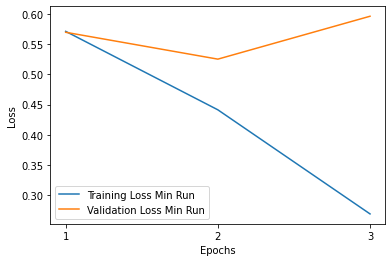

In [ ]:
training_loss_min = [0.5717,0.441300,0.2683]
training_loss_max = [0.5689,0.42830,0.2549]
val_loss_min = [0.570152,0.525531,0.596814]
val_loss_max = [0.548766,0.5161,0.6011]
epoch_list=[1,2,3]

plt.figure()
plt.plot(epoch_list,training_loss_min, label="Training Loss Min Run")
plt.plot(epoch_list,val_loss_min, label="Validation Loss Min Run")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epoch_list)
plt.legend()
plt.show()


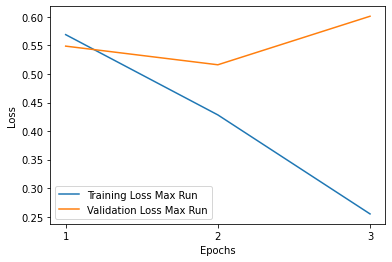

In [ ]:

plt.figure()
plt.plot(epoch_list,training_loss_max, label="Training Loss Max Run")
plt.plot(epoch_list,val_loss_max, label="Validation Loss Max Run")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epoch_list)
plt.legend()
plt.show()